In [1]:
import numpy as np
import pandas as pd
import gc
import time
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("/Users/chienan/Pycon/github/SportLottery/input/FEATURE_AGG_2012TO2019.pkl")

In [3]:
[col for col in df.columns if "LAST_" not in col]

['GAME_ID',
 'TEAM_ID_HOME',
 'TEAM_ID_AWAY',
 'PLUS_MINUS',
 'GAME_DATE',
 'TEAM_ID_H',
 'TEAM_ID_A']

In [4]:
len([col for col in df.columns if "_H" in col])

362

In [5]:
len([col for col in df.columns if ("_A" in col) & ("_H" not in col)])

362

In [6]:
set(df.columns) - set([col for col in df.columns if "_H" in col]) - set([col for col in df.columns if ("_A" in col) & ("_H" not in col)])

{'GAME_DATE', 'GAME_ID', 'PLUS_MINUS'}

In [7]:
df["TEAM_ID_AWAY"] = df["TEAM_ID_AWAY"].astype("category")
df["TEAM_ID_HOME"] = df["TEAM_ID_HOME"].astype("category")

In [8]:
np.percentile(df.loc[:, "PLUS_MINUS"].values, [10, 50, 80]), np.mean(df.loc[:, "PLUS_MINUS"].values)

(array([-14.,   4.,  13.]), 2.697501146263182)

In [9]:
column = ["_".join(col.split("_")[2:-1]) for col in df.columns if ("LAST_1_" in col)&("_H" in col)]

In [10]:
df.loc[df[df.loc[:,"PLUS_MINUS"]>=13].index,"PLUS_MINUS"] = 13
df.loc[df[df.loc[:,"PLUS_MINUS"]<=-14].index,"PLUS_MINUS"] = -14

In [11]:
df.loc[df[df.loc[:,"PLUS_MINUS"]>0].index,"PLUS_MINUS"] = 1
df.loc[df[df.loc[:,"PLUS_MINUS"]<0].index,"PLUS_MINUS"] = 0

In [12]:
new_col = []
for col_i in column:
    new_col += [col for col in df.columns if col_i in col]

In [13]:
new_col = list(set(df.columns)-set(new_col))+list(new_col)

In [14]:
len(set(new_col))

727

In [15]:
df = df[new_col]

In [16]:
df_train = df[df.GAME_ID<"0021700000"].reset_index(drop=True)
df_val = df[(df.GAME_ID<"0021800000")&(df.GAME_ID>"0021700000")].reset_index(drop=True)

In [17]:
x_train = df_train.loc[:, [col for col in df_train.columns if (col not in ["GAME_ID","GAME_DATE","PLUS_MINUS"])&
                          ("TEAM_ID" not in col)]]
x_val = df_val.loc[:, [col for col in df_val.columns if (col not in ["GAME_ID","GAME_DATE","PLUS_MINUS"])&
                        ("TEAM_ID" not in col)]]

In [18]:
y_train = df_train.loc[:, "PLUS_MINUS"]
y_val = df_val.loc[:, "PLUS_MINUS"]

In [19]:
train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_val, y_val)

In [20]:
param = {"metric": ("l1","l2"),
        "objective": "regression_l2"}

In [21]:
param = {"metric": ("binary_error","auc"),
        "objective": "binary"}

In [36]:
evals_result = {}
from bayes_opt import BayesianOptimization


In [46]:
def lgb_eval(learning_rate, num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    evals_result = {}
    params = {'application':'binary','num_iterations': 1000, 'early_stopping_round':100, 'metric':'binary_error'}
    
    params["num_leaves"] = int(round(num_leaves))
    params["learning_rate"] = max(learning_rate, 0)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    result = lgb.train(train_set=train_dataset,valid_sets=[train_dataset, test_dataset] ,evals_result=evals_result,
                       params=params,verbose_eval =200)
    return -min(evals_result['valid_1']['binary_error'])

lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.1),
                                        'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.5, 1),
                                        'max_depth': (4, 9),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=7)

In [47]:
%%time
lgbBO.maximize(init_points=20, n_iter=50)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	training's binary_error: 0.0150607	valid_1's binary_error: 0.365041
Early stopping, best iteration is:
[129]	training's binary_error: 0.062436	valid_1's binary_error: 0.355285
|  1        | -0.3553   |  0.5382   |  0.7239   |  2.192    |  2.17     |  0.09782  |  6.692    |  27.55    |  0.008133 |  29.64    |
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.294341	valid_1's binary_error: 0.36748
Early stopping, best iteration is:
[278]	training's binary_error: 0.284691	valid_1's binary_error: 0.358537
|  2        | -0.3585   |  0.7499   |  0.6434   |  4.019    |  1.143    |  0.007528 |  5.441    |  45.93    |  0.02213  |  33.49    |
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.234537	valid_1's binary_error: 0.369106
Early stopping, best iteration is:
[228]	training's binary_error: 0.222547	valid_1's binary_error: 0.360163
|  3        | -0.3602   |  0.9656   |  0.1199   |  3.003    |  

[200]	training's binary_error: 0.0383097	valid_1's binary_error: 0.368293
Early stopping, best iteration is:
[144]	training's binary_error: 0.0839304	valid_1's binary_error: 0.358537
|  19       | -0.3585   |  0.9633   |  0.4669   |  3.857    |  2.599    |  0.06135  |  8.363    |  6.076    |  0.02789  |  29.82    |
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.244042	valid_1's binary_error: 0.373171
Early stopping, best iteration is:
[113]	training's binary_error: 0.27387	valid_1's binary_error: 0.371545
|  20       | -0.3715   |  0.5603   |  0.8286   |  0.1522   |  2.018    |  0.008063 |  5.804    |  23.81    |  0.01896  |  34.94    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  21       | -0.4236   |  0.6611   |  0.7402   |  1.237    |  0.09023  |  0.001608 |  8.746    |  49.93    |  0.03097  |  44.72    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.244919	valid_1's binary_error: 0.35935
[400]	training's binary_error: 0.178827	valid_1's binary_error: 0.354472
Early stopping, best iteration is:
[355]	training's binary_error: 0.191695	valid_1's binary_error: 0.34878
|  22       | -0.3488   |  0.7946   |  0.547    |  4.754    |  2.791    |  0.01809  |  7.917    |  48.51    |  0.08038  |  24.03    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.176926	valid_1's binary_error: 0.361789
Early stopping, best iteration is:
[116]	training's binary_error: 0.229712	valid_1's binary_error: 0.352846
|  23       | -0.3528   |  0.5474   |  0.5936   |  1.075    |  0.0668   |  0.05077  |  4.122    |  5.014    |  0.07865  |  24.01    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	training's binary_error: 0.211873	valid_1's binary_error: 0.356911
|  24       | -0.3569   |  0.6749   |  0.8248   |  4.229    |  2.882    |  0.09061  |  5.902    |  5.26     |  0.02695  |  44.8     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0168153	valid_1's binary_error: 0.360163
Early stopping, best iteration is:
[194]	training's binary_error: 0.0188624	valid_1's binary_error: 0.352846
|  25       | -0.3528   |  0.7537   |  0.3165   |  1.795    |  0.2406   |  0.04331  |  8.823    |  5.055    |  0.05056  |  44.95    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0595116	valid_1's binary_error: 0.357724
Early stopping, best iteration is:
[133]	training's binary_error: 0.115953	valid_1's binary_error: 0.34878
|  26       | -0.3488   |  0.6273   |  0.2867   |  4.737    |  2.339    |  0.05549  |  8.864    |  26.71    |  0.008048 |  44.91    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.11683	valid_1's binary_error: 0.352033
Early stopping, best iteration is:
[144]	training's binary_error: 0.164498	valid_1's binary_error: 0.342276
|  27       | -0.3423   |  0.6102   |  0.3081   |  4.702    |  0.2046   |  0.09412  |  4.05     |  12.13    |  0.05686  |  44.38    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.243018	valid_1's binary_error: 0.352033
Early stopping, best iteration is:
[200]	training's binary_error: 0.243018	valid_1's binary_error: 0.352033
|  28       | -0.352    |  0.6735   |  0.8786   |  4.514    |  0.2003   |  0.01252  |  8.648    |  16.73    |  0.03819  |  24.16    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.12224	valid_1's binary_error: 0.361789
Early stopping, best iteration is:
[108]	training's binary_error: 0.200029	valid_1's binary_error: 0.354472
|  29       | -0.3545   |  0.7754   |  0.2159   |  4.992    |  2.914    |  0.09836  |  4.036    |  5.659    |  0.02391  |  24.61    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.30911	valid_1's binary_error: 0.365854
[400]	training's binary_error: 0.283813	valid_1's binary_error: 0.35935
Early stopping, best iteration is:
[375]	training's binary_error: 0.287615	valid_1's binary_error: 0.356911
|  30       | -0.3569   |  0.9093   |  0.1078   |  0.01532  |  2.932    |  0.007647 |  4.125    |  16.86    |  0.05178  |  44.88    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	training's binary_error: 0.177073	valid_1's binary_error: 0.343902
|  31       | -0.3439   |  0.9953   |  0.6244   |  4.929    |  0.1663   |  0.09387  |  8.754    |  36.91    |  0.0918   |  44.87    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[38]	training's binary_error: 0.228104	valid_1's binary_error: 0.354472
|  32       | -0.3545   |  0.9454   |  0.8875   |  2.343    |  0.08259  |  0.09845  |  8.602    |  49.52    |  0.06573  |  24.62    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.219769	valid_1's binary_error: 0.352033
Early stopping, best iteration is:
[211]	training's binary_error: 0.212166	valid_1's binary_error: 0.343902
|  33       | -0.3439   |  0.7355   |  0.4822   |  4.705    |  2.013    |  0.05075  |  4.086    |  29.06    |  0.05315  |  24.05    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0402106	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[185]	training's binary_error: 0.0495687	valid_1's binary_error: 0.343089
|  34       | -0.3431   |  0.9485   |  0.747    |  4.143    |  0.358    |  0.04149  |  8.862    |  15.7     |  0.05929  |  44.78    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[32]	training's binary_error: 0.2553	valid_1's binary_error: 0.358537
|  35       | -0.3585   |  0.5912   |  0.1846   |  4.273    |  0.2698   |  0.08481  |  8.764    |  37.5     |  0.08426  |  37.89    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	training's binary_error: 0.286007	valid_1's binary_error: 0.353659
|  36       | -0.3537   |  1.0      |  0.9      |  5.0      |  3.0      |  0.1      |  4.0      |  30.28    |  0.001    |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	training's binary_error: 0.257786	valid_1's binary_error: 0.356098
|  37       | -0.3561   |  0.9812   |  0.4905   |  4.723    |  0.04386  |  0.07732  |  4.39     |  5.625    |  0.02764  |  32.03    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  38       | -0.4236   |  0.6092   |  0.1      |  1.925    |  4.482e-0 |  0.001    |  4.0      |  15.79    |  0.05109  |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	training's binary_error: 0.206902	valid_1's binary_error: 0.353659
|  39       | -0.3537   |  0.7962   |  0.8997   |  4.854    |  2.956    |  0.0939   |  8.989    |  21.77    |  0.06215  |  26.39    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	training's binary_error: 0.153239	valid_1's binary_error: 0.346341
|  40       | -0.3463   |  0.9193   |  0.52     |  3.801    |  0.2637   |  0.07435  |  8.514    |  5.223    |  0.01045  |  24.25    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  41       | -0.4236   |  0.5      |  0.7564   |  0.003142 |  2.754e-0 |  0.001    |  8.998    |  22.06    |  0.09167  |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  42       | -0.4236   |  1.0      |  0.8159   |  5.0      |  3.0      |  0.001    |  4.163    |  13.38    |  0.1      |  36.61    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	training's binary_error: 0.271823	valid_1's binary_error: 0.356098
|  43       | -0.3561   |  0.7873   |  0.1812   |  4.839    |  0.2281   |  0.07404  |  4.071    |  44.07    |  0.06013  |  44.59    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.199298	valid_1's binary_error: 0.366667
[400]	training's binary_error: 0.105425	valid_1's binary_error: 0.352033
Early stopping, best iteration is:
[388]	training's binary_error: 0.11025	valid_1's binary_error: 0.346341
|  44       | -0.3463   |  0.8592   |  0.1778   |  4.509    |  0.005478 |  0.02813  |  8.919    |  35.64    |  0.02433  |  24.09    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	training's binary_error: 0.282351	valid_1's binary_error: 0.355285
|  45       | -0.3553   |  0.5536   |  0.1002   |  5.0      |  3.0      |  0.1      |  8.999    |  42.91    |  0.1      |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  46       | -0.4236   |  0.5      |  0.9      |  1.304e-0 |  3.0      |  0.001    |  4.0      |  50.0     |  0.001    |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	training's binary_error: 0.299751	valid_1's binary_error: 0.350407
|  47       | -0.3504   |  1.0      |  0.1      |  5.0      |  0.0      |  0.1      |  9.0      |  50.0     |  0.1      |  31.75    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.160404	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[140]	training's binary_error: 0.202954	valid_1's binary_error: 0.347154
|  48       | -0.3472   |  0.5      |  0.1      |  3.519    |  0.0      |  0.1      |  4.0      |  32.04    |  0.001    |  43.72    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.250475	valid_1's binary_error: 0.355285
Early stopping, best iteration is:
[291]	training's binary_error: 0.218307	valid_1's binary_error: 0.343902
|  49       | -0.3439   |  0.8132   |  0.3712   |  4.767    |  0.06149  |  0.02668  |  4.472    |  5.01     |  0.0177   |  44.41    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0421114	valid_1's binary_error: 0.356098
Early stopping, best iteration is:
[228]	training's binary_error: 0.0254423	valid_1's binary_error: 0.347154
|  50       | -0.3472   |  0.8347   |  0.1954   |  0.03462  |  2.797    |  0.06886  |  8.586    |  5.415    |  0.07283  |  24.75    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	training's binary_error: 0.262758	valid_1's binary_error: 0.355285
|  51       | -0.3553   |  1.0      |  0.1      |  0.0      |  0.09818  |  0.1      |  4.0      |  5.0      |  0.001    |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.191695	valid_1's binary_error: 0.358537
Early stopping, best iteration is:
[266]	training's binary_error: 0.157041	valid_1's binary_error: 0.347967
|  52       | -0.348    |  0.5063   |  0.1291   |  4.958    |  2.956    |  0.05348  |  5.123    |  37.98    |  0.02495  |  24.65    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.20968	valid_1's binary_error: 0.363415
Early stopping, best iteration is:
[100]	training's binary_error: 0.26188	valid_1's binary_error: 0.360163
|  53       | -0.3602   |  0.963    |  0.1291   |  4.785    |  0.7215   |  0.03219  |  5.031    |  20.24    |  0.0428   |  44.94    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	training's binary_error: 0.217722	valid_1's binary_error: 0.337398
|  54       | -0.3374   |  0.866    |  0.1299   |  4.933    |  0.23     |  0.08796  |  8.824    |  16.49    |  0.04994  |  30.05    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	training's binary_error: 0.187893	valid_1's binary_error: 0.360976
|  55       | -0.361    |  0.6865   |  0.1666   |  4.385    |  1.945    |  0.05862  |  8.967    |  10.85    |  0.03816  |  44.67    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.165229	valid_1's binary_error: 0.362602
Early stopping, best iteration is:
[195]	training's binary_error: 0.168153	valid_1's binary_error: 0.35935
|  56       | -0.3593   |  0.8225   |  0.8688   |  0.1338   |  1.021    |  0.01589  |  8.824    |  5.016    |  0.04247  |  32.14    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.101915	valid_1's binary_error: 0.360976
Early stopping, best iteration is:
[156]	training's binary_error: 0.137739	valid_1's binary_error: 0.349593
|  57       | -0.3496   |  0.9689   |  0.2687   |  0.9631   |  2.679    |  0.05384  |  8.901    |  41.32    |  0.08586  |  24.19    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  58       | -0.4236   |  1.0      |  0.8981   |  5.0      |  5.092e-0 |  0.001    |  4.0      |  32.52    |  0.001    |  24.25    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  59       | -0.4236   |  0.5      |  0.1      |  1.843e-0 |  3.0      |  0.001    |  4.0      |  32.54    |  0.1      |  29.25    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[96]	training's binary_error: 0.192864	valid_1's binary_error: 0.34878
|  60       | -0.3488   |  0.5      |  0.9      |  5.0      |  3.0      |  0.1      |  4.944    |  50.0     |  0.001    |  43.79    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	training's binary_error: 0.251791	valid_1's binary_error: 0.347154
|  61       | -0.3472   |  1.0      |  0.9      |  0.0      |  3.0      |  0.1      |  4.0      |  43.72    |  0.001    |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0501535	valid_1's binary_error: 0.347967
Early stopping, best iteration is:
[137]	training's binary_error: 0.0998684	valid_1's binary_error: 0.339024
|  62       | -0.339    |  0.5852   |  0.1251   |  4.577    |  0.8093   |  0.09101  |  8.112    |  26.79    |  0.0525   |  24.18    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[94]	training's binary_error: 0.0419652	valid_1's binary_error: 0.350407
|  63       | -0.3504   |  0.5      |  0.8074   |  4.939    |  0.0      |  0.1      |  8.851    |  5.453    |  0.001    |  37.5     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[85]	training's binary_error: 0.148267	valid_1's binary_error: 0.355285
|  64       | -0.3553   |  0.9813   |  0.2592   |  4.999    |  2.954    |  0.08781  |  8.823    |  32.78    |  0.06416  |  36.52    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.28703	valid_1's binary_error: 0.372358
[400]	training's binary_error: 0.251353	valid_1's binary_error: 0.361789
[600]	training's binary_error: 0.219477	valid_1's binary_error: 0.355285
[800]	training's binary_error: 0.194327	valid_1's binary_error: 0.346341
Early stopping, best iteration is:
[737]	training's binary_error: 0.201784	valid_1's binary_error: 0.344715
|  65       | -0.3447   |  0.5732   |  0.3795   |  4.982    |  2.996    |  0.006412 |  8.509    |  30.22    |  0.06174  |  24.56    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.112151	valid_1's binary_error: 0.363415
Early stopping, best iteration is:
[215]	training's binary_error: 0.102208	valid_1's binary_error: 0.355285
|  66       | -0.3553   |  0.9791   |  0.1152   |  3.122    |  2.858    |  0.06534  |  5.8      |  26.11    |  0.01405  |  24.08    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	training's binary_error: 0.159234	valid_1's binary_error: 0.355285
|  67       | -0.3553   |  0.5891   |  0.8954   |  3.271    |  2.908    |  0.09179  |  8.994    |  49.97    |  0.002191 |  30.59    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	training's binary_error: 0.200614	valid_1's binary_error: 0.352846
|  68       | -0.3528   |  0.5891   |  0.7597   |  0.9534   |  0.1635   |  0.02977  |  8.999    |  21.62    |  0.01606  |  28.76    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	training's binary_error: 0.216991	valid_1's binary_error: 0.356911
|  69       | -0.3569   |  0.5      |  0.9      |  0.0      |  3.0      |  0.1      |  4.0      |  33.38    |  0.1      |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.325925	valid_1's binary_error: 0.386179
[400]	training's binary_error: 0.292879	valid_1's binary_error: 0.372358
Early stopping, best iteration is:
[418]	training's binary_error: 0.29244	valid_1's binary_error: 0.368293
|  70       | -0.3683   |  0.5047   |  0.3874   |  4.293    |  2.942    |  0.00378  |  5.049    |  38.0     |  0.0551   |  44.93    |
CPU times: user 41min 3s, sys: 3min 54s, total: 44min 57s
Wall time: 18min 20s


In [66]:
lgbBO.res[np.argmax([i["target"] for i in lgbBO.res])]

{'params': {'bagging_fraction': 0.8659721311517226,
  'feature_fraction': 0.12990323999850997,
  'lambda_l1': 4.932979957889549,
  'lambda_l2': 0.22996619845092425,
  'learning_rate': 0.08795888944269456,
  'max_depth': 8.82417808161163,
  'min_child_weight': 16.48843378194777,
  'min_split_gain': 0.04994382474273818,
  'num_leaves': 30.046472146356052},
 'target': -0.33739837398373984}

In [67]:
best_params = lgbBO.res[np.argmax([i["target"] for i in lgbBO.res])]["params"]

In [68]:
best_params

{'bagging_fraction': 0.8659721311517226,
 'feature_fraction': 0.12990323999850997,
 'lambda_l1': 4.932979957889549,
 'lambda_l2': 0.22996619845092425,
 'learning_rate': 0.08795888944269456,
 'max_depth': 8.82417808161163,
 'min_child_weight': 16.48843378194777,
 'min_split_gain': 0.04994382474273818,
 'num_leaves': 30.046472146356052}

In [69]:
best_params["num_leaves"] = int(round(best_params["num_leaves"]))
best_params["max_depth"] = int(round(best_params["max_depth"]))

In [78]:
best_params.update({'num_iterations': 1000,
                    'early_stopping_round':100,
                    "metric": "binary_error"})

In [76]:
best_params

{'bagging_fraction': 0.8659721311517226,
 'early_stopping_round': 50,
 'feature_fraction': 0.12990323999850997,
 'lambda_l1': 4.932979957889549,
 'lambda_l2': 0.22996619845092425,
 'learning_rate': 0.08795888944269456,
 'max_depth': 9,
 'metric': 'binary_error',
 'min_child_weight': 16.48843378194777,
 'min_split_gain': 0.04994382474273818,
 'num_iterations': 1000,
 'num_leaves': 30,
 'verbose': 1}

In [73]:
import pickle

In [64]:
pickle.dump(best_params, open("/Users/chienan/Pycon/github/SportLottery/model/model_params.pkl","wb"),protocol=-1)

In [79]:
%%time 
print("start training...")
model = lgb.train(train_set=train_dataset,
                  valid_sets=[train_dataset, test_dataset] ,
                  verbose_eval=20,
                  params=best_params,
                  evals_result=evals_result)

start training...
Training until validation scores don't improve for 100 rounds.


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's binary_error: 0.266852	valid_1's binary_error: 0.365854
[40]	training's binary_error: 0.223132	valid_1's binary_error: 0.356911
[60]	training's binary_error: 0.182044	valid_1's binary_error: 0.365854
[80]	training's binary_error: 0.147098	valid_1's binary_error: 0.35935
[100]	training's binary_error: 0.11566	valid_1's binary_error: 0.358537
[120]	training's binary_error: 0.0889019	valid_1's binary_error: 0.356911
[140]	training's binary_error: 0.0662378	valid_1's binary_error: 0.346341
[160]	training's binary_error: 0.0507384	valid_1's binary_error: 0.354472
[180]	training's binary_error: 0.0371399	valid_1's binary_error: 0.352846
[200]	training's binary_error: 0.0282205	valid_1's binary_error: 0.357724
[220]	training's binary_error: 0.0228104	valid_1's binary_error: 0.358537
Early stopping, best iteration is:
[136]	training's binary_error: 0.0715017	valid_1's binary_error: 0.344715
CPU times: user 4.88 s, sys: 2.28 s, total: 7.16 s
Wall time: 2.26 s


In [113]:
# model.save_model('/Users/chienan/Pycon/github/SportLottery/model/model_agg_v1.txt')

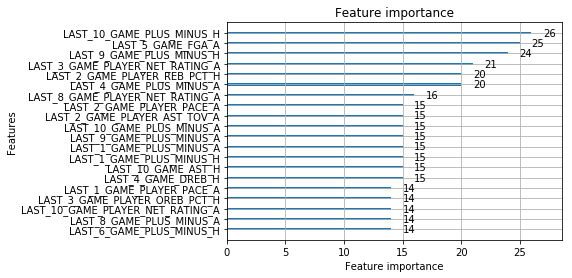

In [65]:
lgb.plot_importance(booster=model,max_num_features=20,importance_type="split")
plt.show()

In [115]:
sum(model.predict(x_val)>0.5), sum(y_val)

(882, 709.0)

In [116]:
# accuracy 
# 0.6365638766519823
sum((model.predict(x_val)>0.5).astype(int)==y_val)/len(y_val)

0.6528455284552845

In [120]:
from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve

In [121]:
f1_score(y_pred=(model.predict(x_val)>0.5).astype(int),y_true=y_val)

0.7316153362664991

In [123]:
precision_score(y_pred=(model.predict(x_val)>0.5).astype(int),y_true=y_val)

0.6598639455782312

In [124]:
recall_score(y_pred=(model.predict(x_val)>0.5).astype(int),y_true=y_val)

0.8208744710860366

In [135]:
precision_recall_curve(probas_pred=model.predict(x_val),y_true=y_val)

(array([0.579722  , 0.57937807, 0.57985258, ..., 0.5       , 0.        ,
        1.        ]),
 array([1.        , 0.99858956, 0.99858956, ..., 0.00141044, 0.        ,
        0.        ]),
 array([0.19871837, 0.2045991 , 0.20840515, ..., 1.00533111, 1.01637953,
        1.02066585]))

In [ ]:
data_lst = [col for col in x_train.columns[model.feature_importance().argsort()][::-1] if "TEAM_ID" not in col]

In [ ]:
data_lst = [col for col in x_train.columns[model.feature_importance().argsort()][::-1] if "TEAM_ID" not in col]
lst = []

while data_lst:
    add_item = list(set([data_lst[0] for i in column if (i in data_lst[0])&("_H" in data_lst[0])] + 
                        [data_lst[0] for i in column if (i in data_lst[0])&("_A" in data_lst[0])]))
    lst += add_item
    data_lst = [col for col in data_lst if "_".join(lst[-1].split("_")[3:]) != "_".join(col.split("_")[3:])]

In [ ]:
x_train = df_train.loc[:,lst]
x_test = df_test.loc[:,lst]

In [ ]:
%%time
print("start training...")
model_v2 = lgb.train(train_set=train_dataset, params=param)

In [ ]:
lgb.plot_importance(booster=model_v2,max_num_features=20,importance_type="split")
plt.show()

In [ ]:
sum((model_v2.predict(x_test)>0.4).astype(int)==y_test)/len(y_test)

In [ ]:
model_v2.predict(x_test)

In [ ]:
sum(y_test[model_v2.predict(x_test)>0.4])/sum((model_v2.predict(x_test)>0.4))

In [ ]:
sum(model_v2.predict(x_test)[y_test.astype(bool)]>0.4)/sum(y_test)

In [ ]:
sum(model_v2.predict(x_test)>0.4)

In [ ]:
sum(y_test),len(y_test)